In [188]:
import bayes3d as b
import genjax
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import jax.tree_util as jtu
console = genjax.pretty(show_locals=False)

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=20.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10000000000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [38]:
contact_plane = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 1.20]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
root_poses = jnp.tile(contact_plane[None, ...],(4,1,1))
all_box_dims = b.RENDERER.model_box_dims

In [228]:
from genjax.generative_functions.distributions import ExactDensity
import bayes3d as b
from dataclasses import dataclass
import jax
import jax.numpy as jnp
import genjax

@dataclass
class GaussianVMFPose(ExactDensity):
    def sample(self, key, pose_mean, var, concentration, **kwargs):
        return b.distributions.gaussian_vmf_sample(key, pose_mean, var, concentration)

    def logpdf(self, pose, pose_mean, var, concentration, **kwargs):
        return b.distributions.gaussian_vmf_logpdf(pose, pose_mean, var, concentration)

@dataclass
class ImageLikelihood(ExactDensity):
    def sample(self, key, img, variance, outlier_prob, outlier_volume):
        return img

    def logpdf(self, image, s, variance, outlier_prob, outlier_volume):
        return b.threedp3_likelihood(image, s, variance, outlier_prob, outlier_volume,5)

@dataclass
class ContactParamsUniform(ExactDensity):
    def sample(self, key, low, high):
        return jax.random.uniform(key, shape=(3,)).reshape(-1,1) * (high - low) + low

    def logpdf(self, sampled_val, low, high, **kwargs):
        valid = ((low <= sampled_val) & (sampled_val <= high))
        log_probs = jnp.log((valid * 1.0) * (jnp.ones_like(sampled_val) / (high-low)))
        return log_probs.sum()

@dataclass
class ContactParamsUniform(ExactDensity):
    def sample(self, key, low, high, arr):
        return jax.random.uniform(key, shape=arr.shape).reshape(-1,1) * (high - low) + low

    def logpdf(self, sampled_val, low, high, arr,**kwargs):
        valid = ((low < sampled_val) & (sampled_val < high))
        log_probs = jnp.log((valid * 1.0) * (jnp.ones_like(sampled_val) / (high-low)))
        return log_probs.sum()

@dataclass
class UniformDiscreteArray(ExactDensity):
    def sample(self, key, vals, arr):
        return jax.random.choice(key, vals, shape=arr.shape)

    def logpdf(self, sampled_val, vals, arr,**kwargs):
        return jnp.log(1.0 / (vals.shape[0])) * arr.shape[0]

@dataclass
class UniformDiscrete(ExactDensity):
    def sample(self, key, vals):
        return jax.random.choice(key, vals)

    def logpdf(self, sampled_val, vals,**kwargs):
        return jnp.log(1.0 / (vals.shape[0]))


gaussian_vmf_pose = GaussianVMFPose()
image_likelihood = ImageLikelihood()
contact_params_uniform = ContactParamsUniform()
uniform_discrete = UniformDiscrete()
uniform_discrete_array = UniformDiscreteArray()



@genjax.gen
def tabletop_model(array, root_poses, all_box_dims):
    indices = jnp.array([-1])
    for i in range(array.shape[0]):
        index = uniform_discrete(jnp.arange(0,22)) @ f"id_{i}"
        indices = jnp.concatenate([indices, jnp.array([index])])
    indices = indices[1:]
        
    contact_params = contact_params_uniform(jnp.array([[-0.2,-0.2, -0.01]]), jnp.array([[0.2,0.2, 2*jnp.pi]]), array) @ "contact_params"
    parents = uniform_discrete_array(jnp.arange(-1,1), array) @ "parents"
    face_parent = uniform_discrete_array(jnp.arange(2,3), array) @ "face_parent"
    face_child = uniform_discrete_array(jnp.arange(3,4), array) @ "face_child"
    box_dims = all_box_dims[indices]
    poses = b.scene_graph.poses_from_scene_graph(root_poses, box_dims, parents, contact_params, face_parent, face_child)
    rendered = b.RENDERER.render_multiobject(
        poses , indices
    )[...,:3]

    variance = genjax.distributions.tfp_uniform(0.00001, 0.1) @ "variance"
    outlier_prob  = genjax.distributions.tfp_uniform(0.00001, 0.001) @ "outlier_prob"
    image_likelihood(rendered, variance, outlier_prob, 100.0) @ "image"
    return rendered, indices, poses

def viz_trace_meshcat(trace, colors=None):
    b.clear()
    key = jax.random.PRNGKey(10)
    b.show_cloud("1", trace["image"].reshape(-1,3))
    # noisy_point_cloud_image = jax.random.multivariate_normal(
    #     key, trace.observation[:,:,:3].reshape(-1,3), jnp.eye(3)*trace.variance
    # )
    # b.show_cloud("2", noisy_point_cloud_image.reshape(-1,3), color=b.RED)
    indices = trace.get_retval()[1]
    print(indices)
    if colors is None:
        colors = b.viz.distinct_colors(max(10, len(indices)))
    for i in range(len(indices)):
        b.show_trimesh(f"obj_{i}", b.RENDERER.meshes[indices[i]],color=colors[i])
        b.set_pose(f"obj_{i}", trace.get_retval()[2][i])

simulate_jit = jax.jit(tabletop_model.simulate)
update_jit = jax.jit(tabletop_model.update)
importance_jit = jax.jit(tabletop_model.importance)
importance_parallel_jit = jax.jit(jax.vmap(tabletop_model.importance, in_axes=(0, None, None)))

In [272]:
render = lambda p: b.RENDERER.render_single_object(p, jnp.int32(1))
render(jnp.zeros((4,4)))
jax.vmap(render, in_axes=(0,))(jnp.zeros((12,4,4)));

In [287]:
render = lambda p: b.RENDERER.render_multiobject(p, jnp.array([0, 1]))
render(jnp.zeros((2,4,4)))
jax.vmap(render, in_axes=(0,))(jnp.zeros((12,2,4,4)))
jax.vmap(render, in_axes=(1,))(jnp.zeros((12,2,4,4)))
jax.vmap(render, in_axes=(0,))(jnp.zeros((2,12,4,4)))
jax.vmap(render, in_axes=(1,))(jnp.zeros((2,12,4,4)))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/envs/bayes3d/lib/python3.8/runpy.py:194 in _run_module_as_main                        │
│                                                                                                  │
│   191 │   main_globals = sys.modules["__main__"].__dict__                                        │
│   192 │   if alter_argv:                                                                         │
│   193 │   │   sys.argv[0] = mod_spec.origin                                                      │
│ ❱ 194 │   return _run_code(code, main_globals, None,                                             │
│   195 │   │   │   │   │    "__main__", mod_spec)                                                 │
│   196                                                                                            │
│   197 def run_module(mod_name, init_globals=None,                                                │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/runpy.py:87 in _run_code                                   │
│                                                                                                  │
│    84 │   │   │   │   │      __loader__ = loader,                                                │
│    85 │   │   │   │   │      __package__ = pkg_name,                                             │
│    86 │   │   │   │   │      __spec__ = mod_spec)                                                │
│ ❱  87 │   exec(code, run_globals)                                                                │
│    88 │   return run_globals                                                                     │
│    89                                                                                            │
│    90 def _run_module_code(code, init_globals=None,                                              │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/ipykernel_launcher.py:17 in <module>         │
│                                                                                                  │
│   14 │                                                                                           │
│   15 │   from ipykernel import kernelapp as app                                                  │
│   16 │                                                                                           │
│ ❱ 17 │   app.launch_new_instance()                                                               │
│   18                                                                                             │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/traitlets/config/application.py:1043 in      │
│ launch_instance                                                                                  │
│                                                                                                  │
│   1040 │   │   """                                                                               │
│   1041 │   │   app = cls.instance(**kwargs)                                                      │
│   1042 │   │   app.initialize(argv)                                                              │
│ ❱ 1043 │   │   app.start()                                                                       │
│   1044                                                                                           │
│   1045                                                                                           │
│   1046 # -----------------------------------------------------------------------------           │
│                                                            

[21  7  7]
[-1  0  0]
[21  7  7]


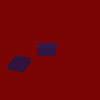

In [229]:
key, (_,gt_trace) = importance_jit(key, genjax.choice_map({
    "parents": jnp.array([-1, 0, 0]), 
    "id_0": jnp.int32(21)
}), (jnp.arange(3), root_poses[:3], all_box_dims,))
viz_trace_meshcat(gt_trace)
print(gt_trace["parents"])
print(gt_trace.get_retval()[1])
# print(gt_trace["contact_params"])
# print(gt_trace["indices"])
observed_image = gt_trace.get_retval()[0]
b.get_depth_image(observed_image[...,2])

In [230]:
VARIANCE_GRID = jnp.array([0.00001, 0.0001, 0.001])
OUTLIER_GRID = jnp.array([0.01, 0.001, 0.0001])
OUTLIER_VOLUME = 100.0

grid_params = [
    (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi/3, (11,11,11)), (0.05, jnp.pi/5, (11,11,1)),
    (0.02, jnp.pi/5, (11,11,11)), (0.02, jnp.pi, (5,5,51))
]
contact_param_gridding_schedule = [
    b.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

key = jax.random.PRNGKey(100)

In [231]:
N = 2
key, (_,trace) = importance_jit(key, genjax.choice_map({
    "parents": jnp.array([-1, 0]), 
    "id_0": jnp.int32(21),
    "contact_params": jnp.zeros((2,3)),
    "image": observed_image
}), (jnp.arange(N), root_poses[:N], all_box_dims,))
viz_trace_meshcat(trace)
print(trace.get_score())

[21 19]
-23892.549


In [232]:
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import Diff

In [250]:
enumerator = lambda trace, c : trace.update(
    key,
    genjax.choice_map({
        "contact_params": c, 
        # "variance": v,
        # "outlier_prob": o,
    }),
    jtu.tree_map(lambda v: Diff(v, NoChange), trace.args),
)[1][2].get_score()
enumerator_jit = jax.jit(enumerator)
enumerator_vmap_jit = jax.jit(jax.vmap(enumerator, in_axes=(None, 0)))

In [251]:
trace.get_score()

Array(-23892.549, dtype=float32)

In [252]:
trace["contact_params"]

Array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [253]:
enumerator_jit(trace, trace["contact_params"])

Array(-23892.549, dtype=float32)

In [257]:
jnp.tile(trace["contact_params"][None, ...], (11,1,1)).shape

(11, 2, 3)

In [254]:
traces = enumerator_vmap_jit(trace, jnp.tile(trace["contact_params"][None, ...], (11, 1,1)))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/envs/bayes3d/lib/python3.8/runpy.py:194 in _run_module_as_main                        │
│                                                                                                  │
│   191 │   main_globals = sys.modules["__main__"].__dict__                                        │
│   192 │   if alter_argv:                                                                         │
│   193 │   │   sys.argv[0] = mod_spec.origin                                                      │
│ ❱ 194 │   return _run_code(code, main_globals, None,                                             │
│   195 │   │   │   │   │    "__main__", mod_spec)                                                 │
│   196                                                                                            │
│   197 def run_module(mod_name, init_globals=None,                                                │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/runpy.py:87 in _run_code                                   │
│                                                                                                  │
│    84 │   │   │   │   │      __loader__ = loader,                                                │
│    85 │   │   │   │   │      __package__ = pkg_name,                                             │
│    86 │   │   │   │   │      __spec__ = mod_spec)                                                │
│ ❱  87 │   exec(code, run_globals)                                                                │
│    88 │   return run_globals                                                                     │
│    89                                                                                            │
│    90 def _run_module_code(code, init_globals=None,                                              │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/ipykernel_launcher.py:17 in <module>         │
│                                                                                                  │
│   14 │                                                                                           │
│   15 │   from ipykernel import kernelapp as app                                                  │
│   16 │                                                                                           │
│ ❱ 17 │   app.launch_new_instance()                                                               │
│   18                                                                                             │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/traitlets/config/application.py:1043 in      │
│ launch_instance                                                                                  │
│                                                                                                  │
│   1040 │   │   """                                                                               │
│   1041 │   │   app = cls.instance(**kwargs)                                                      │
│   1042 │   │   app.initialize(argv)                                                              │
│ ❱ 1043 │   │   app.start()                                                                       │
│   1044                                                                                           │
│   1045                                                                                           │
│   1046 # -----------------------------------------------------------------------------           │
│                                                            

In [ ]:
object_index = 1
contact_param_grid = contact_param_deltas + trace["contact_params"][object_index]
contact_param_full = jnp.tile(trace_.contact_params[None,...], (contact_param_grid.shape[0],1,1))
contact_param_full = contact_param_full.at[:,object_index].set(contact_param_grid)


In [168]:
key, (_,trace) = importance_jit(key, genjax.choice_map({
    "parents": jnp.array([-1, 0, 0, 0]), 
    "indices": jnp.array([21, 0, 1,2]), 
}), (root_poses, all_box_dims,))
print(trace["contact_params"])
print(trace["indices"])
print(trace["parents"])
viz_trace_meshcat(trace)
b.get_depth_image(trace.get_retval()[0][...,2])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_110272/2576835480.py:1 in <module>                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_110272/2576835480.py'                       │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/traceback_util.py:166 in            │
│ reraise_with_filtered_traceback                                                                  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:238 in cache_miss           │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:180 in _python_pjit_helper  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/api.py:311 in infer_params          │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:480 in common_infer_params  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:918 in _pjit_jaxpr          │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/linear_util.py:322 in memoized_fun  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/pjit.py:874 in _create_pjit_jaxpr   │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/profiler.py:314 in wrapper          │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/interpreters/partial_eval.py:2049   │
│ in trace_to_jaxpr_dynamic                                                                        │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/interpreters/partial_eval.py:2066   │
│ in trace_to_subjaxpr_dynamic                                                                     │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.8/site-packages/jax/_src/linear_util.py:166 in call_wrapped  │
│ <@beartype(genjax._src.generative_functions.builtin.builtin_gen_fn.BuiltinGenerativeFunction.imp │
│ ortance) at 0x7f2b01221820>:73 in importance                                                     │
│                                                                                                  │
│ /home/ubuntu/genjax/src/genjax/_src/generative_functions/builtin/builtin_gen_fn.py:164 in        │
│ importance                                                                                       │
│                                                                                                  │
│   161 │   def importance(                                                                        │
│   162 │   │   self, key: PRNGKey, chm: ChoiceMap, args: Tuple, **kwargs                          │
│   163 │   ) -> Tuple[PRNGKey, Tuple[FloatArray, BuiltinTrac